## Overview
This notebook downloads earthquake data (USGS catalog) and plots earthquake magnitudes vs. epicentral distance.

In [37]:
import numpy as np
# Download earthquake catalog data
lusi_coord = (-7.526469, 112.711131) # lat,lon
lusi_lon = lusi_coord[1]
lusi_lat = lusi_coord[0]

data_site    = "https://earthquake.usgs.gov/fdsnws/event/1/query.csv"
text_query = "?starttime=1976-01-01%2000:00:00&endtime=2006-05-27%2023:59:59&latitude=-7.526469&longitude=112.711131&maxradiuskm=1500&minmagnitude=4.0&eventtype=earthquake&orderby=time"
url = data_site + text_query
print("The URL request will be:")
print(url)

The URL request will be:
https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=1976-01-01%2000:00:00&endtime=2006-05-27%2023:59:59&latitude=-7.526469&longitude=112.711131&maxradiuskm=1500&minmagnitude=4.0&eventtype=earthquake&orderby=time


In [38]:
import os
import urllib.request
import shutil

outputFilename = "EQ_Catalog.txt"
os.remove(outputFilename)
with urllib.request.urlopen(url) as response, open(outputFilename, 'wb') as outputFile:
        shutil.copyfileobj(response, outputFile)
outputFile.close()

# Check that the file was downloaded
if os.path.isfile(outputFilename):
    print("File '{}' downloaded OK".format(outputFilename))
else:
    print("Error downloading '{}' ".format(outputFilename))

File 'EQ_Catalog.txt' downloaded OK


In [39]:
# Parse earthquake catalog file
eqfile = open(outputFilename)
header=None
eq_lat = []
eq_lon = []
eq_depth = []
eq_mag = []
eq_time = []
for line in eqfile:
    if header is None:
        header=line
        field_names = header.split(',')
        time_field = field_names.index('time')
        lat_field = field_names.index('latitude')        
        lon_field = field_names.index('longitude')
        mag_field = field_names.index('mag')
        depth_field = field_names.index('depth')
    else:
        fields = line.split(',')
        eq_time.append(fields[time_field])
        eq_lat.append(float(fields[lat_field]))
        eq_lon.append(float(fields[lon_field]))
        eq_mag.append(float(fields[mag_field]))
        eq_depth.append(float(fields[depth_field]))
eqfile.close()
eq_lat = np.array(eq_lat)
eq_lon = np.array(eq_lon)
eq_mag = np.array(eq_mag)
eq_depth = np.array(eq_depth)

In [40]:
# Identify yogyakarta earthquake within catalog
yogyakarta_index = eq_time.index('2006-05-26T22:53:58.920Z')
print(yogyakarta_index)

3


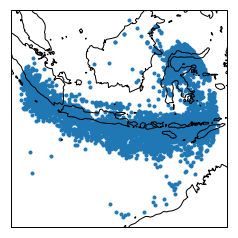

In [41]:
# Make a map of the earthquake positions
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(eq_lon,eq_lat,marker='.',transform=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
plt.show()

In [42]:
import cartopy.geodesic as gd
globe = gd.Geodesic()
result = globe.inverse([0.,0.],[1.,0.])[0][0]
eq_dist_m = []
for lon, lat in zip(eq_lon, eq_lat):
    this_dist = globe.inverse([lusi_lon,lusi_lat],[lon,lat])[0][0]
    eq_dist_m.append(this_dist)
eq_dist_m = np.array(eq_dist_m)
eq_dist_km = eq_dist_m/1000.

In [43]:
# Load the catalog of triggered mud volcano eruptions from csv file (exported from excel spreadsheet)
mv_filename = 'MV_Summary_Table.csv'
mv_file = open(mv_filename,'r')
import csv
header = None
mv_mag = []
mv_dist = []
for line in csv.reader(mv_file, quotechar='"', delimiter=',',quoting=csv.QUOTE_ALL, skipinitialspace=True):
    if header is None:
        header = line
        mag_field = header.index('Magnitude')
        dist_field = header.index('Dist (km)')
    else:
        mv_mag.append(float(line[mag_field]))
        mv_dist.append(float(line[dist_field]))



In [44]:
# Calculate the Wang (2007) energy density curve
wang_mag = np.linspace(4,10,10)
def wang_r(M,e):
    return 10**(0.48*M - 0.33*np.log10(e)-1.4)
def wang_e(M,r):
    return 10**(1./0.33*(0.48*M-np.log10(r)-1.4))

yog_e = wang_e(eq_mag[yogyakarta_index],eq_dist_km[yogyakarta_index])
yog_mag = eq_mag[yogyakarta_index]
yog_dist = eq_dist_km[yogyakarta_index]

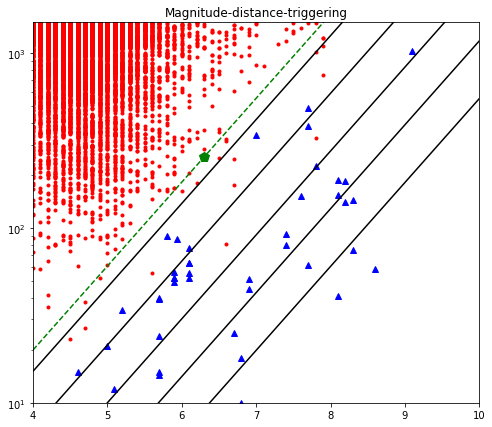

In [45]:
# Make the magnitude-distance plot
fig, ax = plt.subplots(figsize=(8,7))
plt.plot(eq_mag,eq_dist_km,'r.')
plt.plot(eq_mag[yogyakarta_index],eq_dist_km[yogyakarta_index],'gp',markersize=10)
plt.plot(mv_mag,mv_dist,'b^')
plt.plot(wang_mag,wang_r(wang_mag,1e-2),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e-1),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e0),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e1),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e2),'k')
plt.plot(wang_mag,wang_r(wang_mag,yog_e),'g--')

ax.set_yscale('log')
ax.set_xlim([4, 10])
ax.set_ylim([10,1500])
plt.title('Magnitude-distance-triggering')
plt.show()


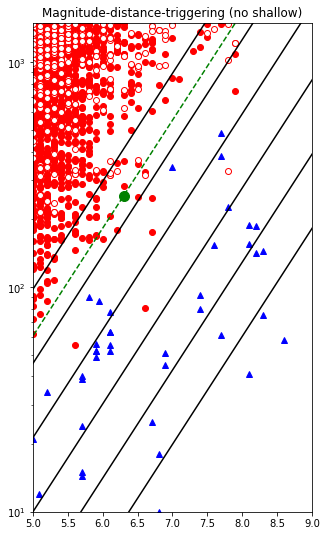

In [46]:
# Make a second figure excluding shallow events
minimum_depth = 30.
fig, ax = plt.subplots(figsize=(5,9))
plt.plot(eq_mag[eq_depth > minimum_depth],eq_dist_km[eq_depth > minimum_depth],'ro')
plt.plot(eq_mag[eq_depth <= minimum_depth],eq_dist_km[eq_depth <= minimum_depth],linestyle='none',marker='o',markerfacecolor='w',markeredgecolor='r')
plt.plot(eq_mag[yogyakarta_index],eq_dist_km[yogyakarta_index],'g.',markersize=20)
plt.plot(mv_mag,mv_dist,'b^')
plt.plot(wang_mag,wang_r(wang_mag,1e-3),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e-2),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e-1),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e0),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e1),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e2),'k')
plt.plot(wang_mag,wang_r(wang_mag,yog_e),'g--')

ax.set_yscale('log')
ax.set_xlim([5, 9])
ax.set_ylim([10,1500])
plt.title('Magnitude-distance-triggering (no shallow)')
plt.show()

In [51]:
# Calculate the Wang (2007) seismic energy density for every event in the catalog.
eq_e = wang_e(eq_mag, eq_dist_km)
print('Deep events whith seismic energy density equal or greater than Yogyakarta')
for i in range(len(eq_e)):
    if eq_e[i] >= yog_e and eq_depth[i] > minimum_depth:
        print(eq_time[i],eq_mag[i],eq_dist_km[i],'\t',eq_lat[i],eq_lon[i])
        

Deep events whith seismic energy density equal or greater than Yogyakarta
2005-07-09T22:42:04.080Z 4.4 1.97115934568 	 -7.517 112.696
2005-01-20T16:09:44.760Z 4.7 26.7115982959 	 -7.68 112.898
2000-06-04T16:28:26.170Z 7.9 1216.07079338 	 -4.721 102.087
2000-05-07T19:21:52.040Z 4.9 51.7795123978 	 -7.985 112.806
1998-09-28T13:34:30.490Z 6.6 80.8156913475 	 -8.194 112.413
1996-06-17T11:22:18.540Z 7.9 1091.49431319 	 -7.137 122.589
1996-01-09T15:31:33.570Z 4.5 23.2852176597 	 -7.655 112.544
1994-09-28T16:39:51.670Z 6.6 324.174730787 	 -5.786 110.352
1992-12-27T21:49:04.470Z 6.0 163.53829537 	 -6.087 113.05
1992-09-02T05:50:01.900Z 6.7 175.55526211 	 -6.046 112.138
1992-05-14T18:19:11.160Z 4.7 37.5426663641 	 -7.376 113.016
1985-08-08T16:18:02.630Z 6.2 179.575335663 	 -6.102 113.491
1984-07-09T23:19:03.570Z 6.7 247.742158778 	 -5.788 111.298
1978-10-14T18:41:13.700Z 5.6 55.0848483156 	 -7.464 112.216
1977-08-19T06:08:55.200Z 7.9 744.466371148 	 -11.085 118.464
1976-07-14T07:13:24.000Z 6.5 

In [52]:
# Calculate the Wang (2007) seismic energy density for every event in the catalog.
eq_e = wang_e(eq_mag, eq_dist_km)
print('ALL events whith seismic energy density equal or greater than Yogyakarta')
for i in range(len(eq_e)):
    if eq_e[i] >= yog_e:
        print(eq_time[i],eq_mag[i],eq_dist_km[i],'\t',eq_lat[i],eq_lon[i])
        

ALL events whith seismic energy density equal or greater than Yogyakarta
2006-05-26T22:53:58.920Z 6.3 254.447385955 	 -7.961 110.446
2005-07-09T22:42:04.080Z 4.4 1.97115934568 	 -7.517 112.696
2005-01-20T16:09:44.760Z 4.7 26.7115982959 	 -7.68 112.898
2000-06-04T16:28:26.170Z 7.9 1216.07079338 	 -4.721 102.087
2000-05-07T19:21:52.040Z 4.9 51.7795123978 	 -7.985 112.806
1998-09-28T13:34:30.490Z 6.6 80.8156913475 	 -8.194 112.413
1996-06-17T11:22:18.540Z 7.9 1091.49431319 	 -7.137 122.589
1996-01-09T15:31:33.570Z 4.5 23.2852176597 	 -7.655 112.544
1996-01-01T08:05:10.830Z 7.9 1214.88487454 	 0.729 119.931
1994-09-28T16:39:51.670Z 6.6 324.174730787 	 -5.786 110.352
1994-06-03T21:06:59.880Z 6.6 314.243543769 	 -10.362 112.892
1994-06-02T18:17:34.020Z 7.8 326.617784152 	 -10.477 112.835
1992-12-27T21:49:04.470Z 6.0 163.53829537 	 -6.087 113.05
1992-12-12T05:29:26.350Z 7.8 1018.00568775 	 -8.48 121.896
1992-09-02T05:50:01.900Z 6.7 175.55526211 	 -6.046 112.138
1992-05-14T18:19:11.160Z 4.7 37